In [1]:
import numpy as np
import tensorflow as tf
import edward2 as ed
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow_probability as tfp

In [2]:
tf.__version__

'2.0.0'

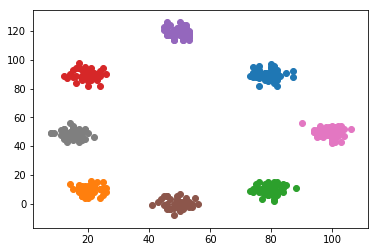

In [3]:
n_samps = 50

means = np.array([[8,9], [2,1], [8,1], [2,9], [5,12], [5,0], [10, 5], [1.5,5]]) * 10
data = np.zeros((len(means)*n_samps,2))
y = np.zeros((len(means)*n_samps,1))
for ind, m in enumerate(means):
    samps = multivariate_normal(m, np.eye(2)/0.1).rvs(n_samps).astype(int)
    data[ind*n_samps:((ind+1)*n_samps)] = samps
    y[ind*n_samps:((ind+1)*n_samps)] = np.tile(ind, n_samps).reshape(-1,1)
    plt.scatter(samps[:,0], samps[:,1])


In [4]:
data.shape

(400, 2)

In [44]:
# this is converting all of the integers to onehots but this doesnt have to be the case. 
#need to change the base distribution and the data onehot conversion. 

batch_size, sequence_length, vocab_size = 32,  2, 150

temperature = 0.1

# Define the model.
# , order='right-to-left' was on one of them but threw an error. 
units = vocab_size
# hidden_dims=[64, 64]
flow = tf.keras.Sequential([
  ed.layers.DiscreteAutoregressiveFlow(ed.layers.MADE(vocab_size, hidden_dims=[64,64]), temperature),
  ed.layers.DiscreteAutoregressiveFlow(ed.layers.MADE(vocab_size, hidden_dims=[64,64]), temperature),
  ed.layers.DiscreteAutoregressiveFlow(ed.layers.MADE(vocab_size, hidden_dims=[64,64]), temperature),
])

# WHAT IS THE DIFFERENCE BETXWEEN A ONEHOT CATEGORICAL AND A NON ONEHOT CATEGORICAL? BEFORE I WAS GETTING ERRORS AND THE CATEGORICAL WAS WARPING MY DIMENSIONS

# the probs for everything are distributed randomly accoring to a standard normal but they are then exponentiated. 
base = ed.OneHotCategorical(logits=tf.Variable(tf.random.normal([batch_size, sequence_length, vocab_size])), dtype=tf.float32)

# Specify custom loss function and run training loop. Or use model.compile and
# model.fit.

'''def loss_fun(ground, passed):
    
    for l in reversed(flow.layers):
        pass
    
    return tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=flow.reverse(features),
          logits=model_rv.distribution.base.logits))'''

def loss_fn(ground, passed):
    '''print('features and then underscore', features,_)
    temp = features
    for l in flow.layers:
        temp = l.reverse(temp)
    whitened_features = temp #flow.reverse(features)
    print('whitenend features', whitened_features )'''
    # In this example, we don't include log-det-jacobian as in continuous flows.
    # Discrete flows don't require them.
    loss = -tf.reduce_mean(base.distribution.log_prob(passed))
    print(loss)
    return loss

In [54]:
model(base).distribution.base.logits == base.distribution.logits

<tf.Tensor: id=4134, shape=(32, 2, 150), dtype=bool, numpy=
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       ...,

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])>

In [53]:
base.distribution.logits

<tf.Variable 'Variable:0' shape=(32, 2, 150) dtype=float32, numpy=
array([[[ 0.99898505, -3.0071876 ,  0.9466668 , ..., -0.48307407,
         -0.59963876,  0.13651057],
        [-0.18276516,  0.94058913,  0.6285583 , ..., -1.2661057 ,
         -0.41118056,  1.8518987 ]],

       [[ 2.4963868 , -0.13002376,  2.110603  , ...,  2.1656876 ,
          0.21204825,  0.3323681 ],
        [ 0.62958723,  0.6910536 , -1.2692233 , ...,  1.282104  ,
          0.607685  , -0.9027876 ]],

       [[-0.48283204,  1.7185917 , -0.65634775, ..., -0.63169897,
         -0.3940288 , -0.10424085],
        [ 0.12355497,  1.2653755 ,  0.41304323, ..., -1.1233234 ,
          0.9589236 ,  0.3922753 ]],

       ...,

       [[ 0.6264887 ,  0.11475684,  1.0336145 , ...,  0.3981701 ,
         -0.1834339 ,  0.7487567 ],
        [ 0.2978813 , -1.7587211 ,  1.2739275 , ..., -0.12416731,
         -0.8823826 , -0.03147049]],

       [[-0.17006683, -1.3160901 ,  0.9026324 , ..., -1.0118151 ,
         -0.27005193,  0.87306

In [46]:
def one_hotter(x, depth):
    idd = np.eye(depth)
    print(idd[0])
    res = np.zeros((x.shape[0], x.shape[1], depth))
    print(res.shape)
    for ind in range(len(x)): 
        for j, val in enumerate(x[ind]):
            res[ind, j, :] = idd[int(val)]
            
    return res
            

oh = one_hotter(data, vocab_size)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(400, 2, 150)


In [47]:
oh[:batch_size, :, :].shape

(32, 2, 150)

In [8]:
loss_fn(0,flow(oh[:batch_size,:,:]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(5.624161, shape=(), dtype=float32)


<tf.Tensor: id=3435, shape=(), dtype=float32, numpy=5.624161>

In [9]:
#base.distribution.log_prob(oh[:batch_size, :, :])

In [10]:
# this command here is buggy :/
#tf.one_hot(data, depth=vocab_size, dtype=tf.float32)

2 150
(2, 1000)


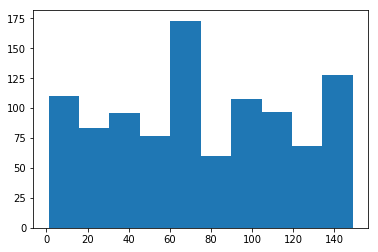

(array([ 52.,  78., 150., 137., 116.,  72.,  83.,  73., 109., 130.]),
 array([  0. ,  14.9,  29.8,  44.7,  59.6,  74.5,  89.4, 104.3, 119.2,
        134.1, 149. ]),
 <a list of 10 Patch objects>)

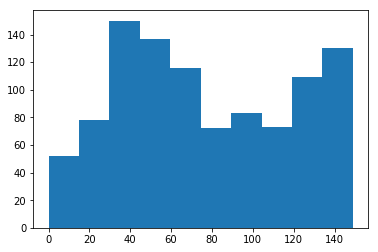

In [11]:
# example of the multinomail that should really be one hotted. 
tfd = tfp.distributions
print(sequence_length, vocab_size)
cat = tfd.Categorical(logits=tf.Variable(tf.random.normal([sequence_length, vocab_size])))
s = tfd.Sample(
    cat,
    sample_shape=1000)
x = s.sample()
print(x.shape)
plt.hist(x[0,:])
plt.show()
plt.hist(x[1,:])

In [12]:
def alt_loss_fn(features):
    #print('features and then underscore', features)
    whitened_features = flow_s.reverse(features) #flow.reverse(features)
    #print('whitenend features', whitened_features )
    # In this example, we don't include log-det-jacobian as in continuous flows.
    # Discrete flows don't require them.
    loss = -tf.reduce_mean(base.distribution.log_prob(whitened_features))
    print('this is the loss',loss)
    return loss

In [42]:
flow_s(oh[:batch_size,:,:])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: id=798409, shape=(32, 2, 150), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [43]:
flow_s.reverse(oh[:batch_size,:,:])

<tf.Tensor: id=798461, shape=(32, 2, 150), dtype=float32, numpy=
array([[[-8.24530915e-08, -7.01892455e-09,  3.79447052e-08, ...,
         -3.98574791e-08, -3.62204702e-08, -2.58645443e-08],
        [-1.15235652e-08, -1.37591741e-07, -1.77923226e-07, ...,
         -1.61436393e-08, -3.37019145e-07, -1.73112966e-07]],

       [[ 3.21865095e-08, -3.80087677e-08,  9.93571376e-08, ...,
          1.42955201e-07,  1.66220076e-07, -2.21102098e-07],
        [-3.97364310e-08, -5.39880851e-08,  1.01881078e-07, ...,
         -7.46040598e-08,  6.36336450e-09, -1.65533134e-08]],

       [[-1.00334487e-08, -1.69801897e-08,  5.04879303e-08, ...,
          1.66768913e-07, -2.02878834e-08, -1.00980010e-07],
        [ 1.09275184e-08,  1.18134430e-07, -3.48332776e-08, ...,
         -1.07304999e-07, -3.33523325e-08, -1.84815264e-07]],

       ...,

       [[ 3.21865095e-08, -3.80087677e-08,  9.93571376e-08, ...,
          1.42955201e-07,  1.66220076e-07, -2.21102098e-07],
        [-3.41733291e-08,  2.44787

In [39]:
network = ed.layers.MADE(vocab_size, hidden_dims=[64,64])
flow_s = ed.layers.DiscreteAutoregressiveFlow(network, temperature)
import copy
opt = tf.keras.optimizers.Adam()
epochs = 300
@tf.function
def train(model, dataset, optimizer, epochs=10):
    
    losses = []
    for e in range(epochs):
        if e%25==0:
            print('epoch',e)
        #passed = model(dataset[:batch_size,:,:])
        model_rv = model(base)
        with tf.GradientTape() as t:
            
            #current_loss = -tf.reduce_mean(base.distribution.log_prob(passed))
            current_loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(
                labels=model.reverse(dataset[:batch_size,:,:]),
              logits=model_rv.distribution.base.logits)) #alt_loss_fn(oh[:batch_size])
            #temp_loss = copy.deepcopy(current_loss)
            losses.append(current_loss)
        #print(current_loss)
        gradients = t.gradient(current_loss, model.weights)
        #print('GRADIENTS',gradients)
        # zip(grads,network_.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.weights))
    return losses
    
losses = train(flow_s, oh,  opt, epochs=epochs)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



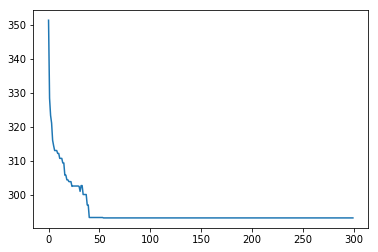

In [40]:
plt.plot(losses)

In [55]:
base.value

<tf.Tensor: id=798483, shape=(32, 2, 150), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

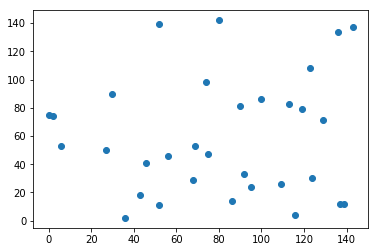

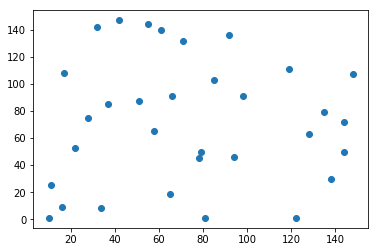

In [59]:
rands = base.value
rands_max = np.argmax(rands, axis=2)
plt.scatter(rands_max[:,0], rands_max[:,1])
plt.show()
samps = flow_s(rands)
samps = samps.numpy().argmax(axis=-1)
plt.scatter( samps[:,0], samps[:,1])

In [18]:
flow.compile(optimizer='adam',
              loss=loss_fn)
              #metrics=None)

In [19]:
flow.fit(oh, y, epochs=10, batch_size=batch_size)

Tensor("loss/output_1_loss/Neg:0", shape=(), dtype=float32)
Train on 400 samples
Epoch 1/10
Tensor("loss/output_1_loss/Neg:0", shape=(), dtype=float32)
 32/400 [=>............................] - ETA: 17s

ValueError: No gradients provided for any variable: ['sequential_3/discrete_autoregressive_flow/made/sequential/dense/kernel:0', 'sequential_3/discrete_autoregressive_flow/made/sequential/dense/bias:0', 'sequential_3/discrete_autoregressive_flow/made/sequential/dense_1/kernel:0', 'sequential_3/discrete_autoregressive_flow/made/sequential/dense_1/bias:0', 'sequential_3/discrete_autoregressive_flow/made/sequential/dense_2/kernel:0', 'sequential_3/discrete_autoregressive_flow/made/sequential/dense_2/bias:0', 'sequential_3/discrete_autoregressive_flow_1/made_1/sequential_1/dense_3/kernel:0', 'sequential_3/discrete_autoregressive_flow_1/made_1/sequential_1/dense_3/bias:0', 'sequential_3/discrete_autoregressive_flow_1/made_1/sequential_1/dense_4/kernel:0', 'sequential_3/discrete_autoregressive_flow_1/made_1/sequential_1/dense_4/bias:0', 'sequential_3/discrete_autoregressive_flow_1/made_1/sequential_1/dense_5/kernel:0', 'sequential_3/discrete_autoregressive_flow_1/made_1/sequential_1/dense_5/bias:0', 'sequential_3/discrete_autoregressive_flow_2/made_2/sequential_2/dense_6/kernel:0', 'sequential_3/discrete_autoregressive_flow_2/made_2/sequential_2/dense_6/bias:0', 'sequential_3/discrete_autoregressive_flow_2/made_2/sequential_2/dense_7/kernel:0', 'sequential_3/discrete_autoregressive_flow_2/made_2/sequential_2/dense_7/bias:0', 'sequential_3/discrete_autoregressive_flow_2/made_2/sequential_2/dense_8/kernel:0', 'sequential_3/discrete_autoregressive_flow_2/made_2/sequential_2/dense_8/bias:0'].

In [31]:
out = flow(oh[:batch_size])
loss = loss_fn(0, out)

features and then underscore tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(32, 2, 150), dtype=float32) 0
whitenend features tf.Tensor(
[[[ 4.39087557e-08 -1.16304342e-07  1.81788209e-07 ... -1.47833745e-07
    4.70543888e-08 -1.89775903e-07]
  [-4.76837165e-08  4.61427518e-08  1.74542024e-07 ... -1.25894772e-07
    7.95030033e-08  5.46614096e-08]]

 [[-5.08268704e-06 -7.65686679e-08 -1.07436868e-07 ... -4.60467620e-09
    1.02714985e-07 -8.60671676e-08]
  [-1.48614248e-07 -3.07907925e-07  8.86944008e-07 ... -8.70709016e-08
   -8.00550204e-09  2.43305038e-07]]

 [[ 1.22189519e-07 -8.24203923e-08  7.32002192e-08 ... -3.71855791e-09
   -4.41420234e-09 -6.77529144e-08]
  [ 4.27961368e-07  5.8

features and then underscore Tensor("discrete_autoregressive_flow_6/concat_1:0", shape=(32, 2, 150), dtype=float32) 0
whitenend features Tensor("Real_2:0", shape=(32, 2, 150), dtype=float32)
Tensor("Neg:0", shape=(), dtype=float32)
GRADIENTS [None, None, None, None, None, None]


In [36]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss_fn(0, out))

features and then underscore tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(32, 2, 150), dtype=float32) 0
whitenend features tf.Tensor(
[[[ 4.39087557e-08 -1.16304342e-07  1.81788209e-07 ... -1.47833745e-07
    4.70543888e-08 -1.89775903e-07]
  [-4.76837165e-08  4.61427518e-08  1.74542024e-07 ... -1.25894772e-07
    7.95030033e-08  5.46614096e-08]]

 [[-5.08268704e-06 -7.65686679e-08 -1.07436868e-07 ... -4.60467620e-09
    1.02714985e-07 -8.60671676e-08]
  [-1.48614248e-07 -3.07907925e-07  8.86944008e-07 ... -8.70709016e-08
   -8.00550204e-09  2.43305038e-07]]

 [[ 1.22189519e-07 -8.24203923e-08  7.32002192e-08 ... -3.71855791e-09
   -4.41420234e-09 -6.77529144e-08]
  [ 4.27961368e-07  5.8

RuntimeError: `loss` passed to Optimizer.compute_gradients should be a function when eager execution is enabled.

In [ ]:
print(flow.trainable_variables())

In [ ]:
batch_size = 2
length = 4
loc_only=False
vocab_size = 5
if loc_only:
    units = vocab_size
    network = ed.layers.MADE(units, [])
else:
    units = 2 * vocab_size
    mask = tf.reshape([0] * vocab_size + [-1e10] + [0] * (vocab_size - 1),
                    [1, 1, 2 * vocab_size])
    network_ = ed.layers.MADE(units, [])
    network = lambda inputs, **kwargs: mask + network_(inputs, **kwargs)
base = ed.OneHotCategorical(logits=tf.random.normal([batch_size,
                                                     length,
                                                     vocab_size]),
                            dtype=tf.float32)
flow = ed.layers.DiscreteAutoregressiveFlow(network, 1.)
flow_rv = flow(base)


#flow.evaluate(tf1.global_variables_initializer())
#res = flow.evaluate(flow_rv)


inputs = np.random.randint(0, vocab_size - 1, size=(batch_size, length))
inputs = tf.one_hot(inputs, depth=vocab_size, dtype=tf.float32)
outputs = flow(inputs)
rev_outputs = flow.reverse(outputs)
#inputs_val, rev_outputs_val = #([inputs, rev_outputs])


inputs_log_prob = base.distribution.log_prob(inputs)
outputs_log_prob = flow_rv.distribution.log_prob(outputs)
#res1, res2 = self.evaluate([inputs_log_prob, outputs_log_prob])


In [25]:
batch_size = 2
length = 4
vocab_size = 2
loc_only = True

opt = tf.keras.optimizers.SGD(learning_rate=0.1)

if loc_only:
  units = vocab_size
  network_ = ed.layers.MADE(units, [16, 16])
  network = network_
else:
  units = 2 * vocab_size
  network_ = ed.layers.MADE(units, [16, 16])
  mask = tf.reshape([0] * vocab_size + [-1e10] + [0] * (vocab_size - 1),
                    [1, 1, 2 * vocab_size])
  network = lambda inputs, **kwargs: mask + network_(inputs, **kwargs)
with tf.GradientTape() as tape:
  base = ed.OneHotCategorical(
      logits=tf.random.normal([batch_size, length, vocab_size]))
  flow = ed.layers.DiscreteAutoregressiveFlow(network, 1.)
  flow_rv = flow(base)
  features = np.random.randint(0, vocab_size - 1, size=(batch_size, length))
  features = tf.one_hot(features, depth=vocab_size, dtype=tf.float32)
  loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(
      labels=flow.reverse(features),
      logits=flow_rv.distribution.base.logits))
grads = tape.gradient(loss, network_.trainable_weights)
opt.minimize(loss, network_.trainable_weights)
'''self.evaluate(tf1.global_variables_initializer())
_ = self.evaluate(grads)
for grad in grads:
  self.assertIsNotNone(grad)'''


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object is not callable

In [29]:



batch_size = 2
length = 4
vocab_size = 2
loc_only = True

opt = tf.keras.optimizers.SGD(learning_rate=0.1)

if loc_only:
  units = vocab_size
  network_ = ed.layers.MADE(units, [16, 16])
  network = network_
else:
  units = 2 * vocab_size
  network_ = ed.layers.MADE(units, [16, 16])
  mask = tf.reshape([0] * vocab_size + [-1e10] + [0] * (vocab_size - 1),
                    [1, 1, 2 * vocab_size])
  network = lambda inputs, **kwargs: mask + network_(inputs, **kwargs)
    
base = ed.OneHotCategorical(
logits=tf.random.normal([batch_size, length, vocab_size]))
flow = ed.layers.DiscreteAutoregressiveFlow(network, 1.)
flow_rv = flow(base)
features = np.random.randint(0, vocab_size - 1, size=(batch_size, length))
features = tf.one_hot(features, depth=vocab_size, dtype=tf.float32)
with tf.GradientTape() as tape:
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(
        labels=flow.reverse(features),
        logits=flow_rv.distribution.base.logits))
grads = tape.gradient(loss, network_.trainable_weights)
opt.apply_gradients(zip(grads,network_.trainable_weights))
#opt.minimize(loss, network_.trainable_weights)



<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [68]:
base.distribution.log_prob(inputs)

<tf.Tensor: id=23497, shape=(2, 4), dtype=float32, numpy=
array([[-4.1944447 , -1.7323816 , -0.9144609 , -3.8651865 ],
       [-1.5306695 , -0.93880343, -2.4575806 , -1.8257781 ]],
      dtype=float32)>

In [66]:
print(batch_size,
                                                     length,
                                                     vocab_size)

2 4 5


In [67]:
rev_outputs

<tf.Tensor: id=23263, shape=(2, 4, 5), dtype=float32, numpy=
array([[[ 3.57627883e-08,  5.22515613e-08,  1.02429908e-07,
          9.99999702e-01,  1.19987362e-07],
        [-3.57627883e-08,  6.89621649e-09,  9.99999821e-01,
          8.45745518e-08,  5.60555691e-08],
        [ 1.07288365e-07,  9.99999702e-01,  1.23809542e-07,
         -1.26952484e-08,  1.49860625e-07],
        [-3.57627883e-08,  6.89621649e-09,  9.99999821e-01,
          8.45745518e-08,  5.60555691e-08]],

       [[ 7.45058060e-08,  9.99999702e-01,  3.16178870e-08,
          1.62374540e-08,  6.92420130e-08],
        [ 3.57627883e-08,  5.22515613e-08,  1.02429908e-07,
          9.99999702e-01,  1.19987362e-07],
        [ 5.96046457e-09,  1.09662913e-07,  9.99999702e-01,
          1.23093386e-07,  4.76912412e-08],
        [ 5.06639495e-08,  9.99999821e-01, -6.92426727e-10,
          1.56020747e-07,  1.22815225e-08]]], dtype=float32)>

In [90]:
import tensorflow as tf
perm = tf.math.floormod(
        tf.tile(tf.range(vocab_size)[:, tf.newaxis], [1, vocab_size]) *
        tf.range(vocab_size)[tf.newaxis], vocab_size)

In [92]:
perm.shape

TensorShape([150, 150])

In [91]:
tf.one_hot(perm, depth=vocab_size, axis=-1)

<tf.Tensor: id=802880, shape=(150, 150, 150), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
   

In [69]:
tf.tile(tf.range(vocab_size)[:, tf.newaxis], [1, vocab_size])

<tf.Tensor: id=802836, shape=(150, 150), dtype=int32, numpy=
array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [147, 147, 147, ..., 147, 147, 147],
       [148, 148, 148, ..., 148, 148, 148],
       [149, 149, 149, ..., 149, 149, 149]], dtype=int32)>

In [80]:
tf.tile(tf.range(vocab_size)[:, tf.newaxis], [1, vocab_size]) * tf.range(vocab_size)[tf.newaxis]

<tf.Tensor: id=802855, shape=(150, 150), dtype=int32, numpy=
array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     1,     2, ...,   147,   148,   149],
       [    0,     2,     4, ...,   294,   296,   298],
       ...,
       [    0,   147,   294, ..., 21609, 21756, 21903],
       [    0,   148,   296, ..., 21756, 21904, 22052],
       [    0,   149,   298, ..., 21903, 22052, 22201]], dtype=int32)>

In [70]:
import torch

In [78]:
torch.arange(vocab_size).unsqueeze(1).repeat(1,vocab_size)

tensor([[  0,   0,   0,  ...,   0,   0,   0],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  2,   2,   2,  ...,   2,   2,   2],
        ...,
        [147, 147, 147,  ..., 147, 147, 147],
        [148, 148, 148,  ..., 148, 148, 148],
        [149, 149, 149,  ..., 149, 149, 149]])

In [84]:
a = torch.arange(vocab_size).unsqueeze(1).repeat(1,vocab_size) * torch.arange(vocab_size)

In [86]:
a

tensor([[    0,     0,     0,  ...,     0,     0,     0],
        [    0,     1,     2,  ...,   147,   148,   149],
        [    0,     2,     4,  ...,   294,   296,   298],
        ...,
        [    0,   147,   294,  ..., 21609, 21756, 21903],
        [    0,   148,   296,  ..., 21756, 21904, 22052],
        [    0,   149,   298,  ..., 21903, 22052, 22201]])

In [87]:
def floorMod(a,b):
    return a - (torch.floor(torch.div(a,b).float())*b)

In [93]:
perm= floorMod(a, vocab_size)

In [110]:
z = torch.zeros((150*150,150))

In [111]:
p_f = perm.flatten().long().unsqueeze(1)

In [114]:
oh = z.scatter_(1,p_f,1)
oh.shape

torch.Size([22500, 150])

In [115]:
oh.view(150,150,150)

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        ...,

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [37]:
nh = 24
vocab_size = 150
temperature = 0.1

network = ed.layers.MADE(vocab_size, hidden_dims=[nh,nh,nh, vocab_size*2])
model = ed.layers.DiscreteAutoregressiveFlow(network, temperature)

'''layer = MADE(vocab_size, [nh, nh, nh], vocab_size, num_masks=1, natural_ordering=True)
model = DiscreteAutoregressiveFlow( layer, temperature, vocab_size )'''

'layer = MADE(vocab_size, [nh, nh, nh], vocab_size, num_masks=1, natural_ordering=True)\nmodel = DiscreteAutoregressiveFlow( layer, temperature, vocab_size )'

In [38]:
for l in network.network.layers:
    print(l)

In [39]:
oh.shape

(400, 2, 150)

In [40]:
layer.forward(torch.tensor(oh[:64,:,:vocab_size]).float()).shape

NameError: name 'layer' is not defined

In [41]:
oh[:64,:,:vocab_size].argmax(-1)

array([[82, 86],
       [81, 93],
       [74, 88],
       [79, 89],
       [81, 92],
       [82, 82],
       [80, 86],
       [79, 85],
       [79, 91],
       [80, 88],
       [75, 92],
       [77, 90],
       [76, 93],
       [78, 86],
       [78, 89],
       [76, 82],
       [85, 91],
       [78, 88],
       [80, 87],
       [78, 91],
       [82, 93],
       [81, 90],
       [78, 90],
       [74, 91],
       [81, 87],
       [87, 92],
       [82, 91],
       [79, 88],
       [79, 86],
       [80, 97],
       [81, 95],
       [76, 96],
       [81, 96],
       [75, 88],
       [80, 88],
       [73, 89],
       [87, 88],
       [78, 89],
       [80, 94],
       [76, 88],
       [77, 89],
       [81, 94],
       [75, 89],
       [80, 95],
       [76, 87],
       [81, 84],
       [74, 91],
       [78, 91],
       [74, 95],
       [83, 89],
       [19,  4],
       [18,  5],
       [25, 11],
       [19,  5],
       [23, 15],
       [19, 11],
       [18,  8],
       [24,  4],
       [21,  5

In [42]:
network( oh[:64,:,:vocab_size] )[0,0,:] == network( oh[:64,:,:vocab_size] )[0,1,:]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: id=1993, shape=(150,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, F

In [43]:
model( oh[:64,:,:vocab_size] )


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: id=3045, shape=(64, 2, 150), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [262]:
torch.tensor(10).type(torch.int32)

tensor(10, dtype=torch.int32)